In [1]:
import sys
sys.path.append("/home/ubuntu/roaddetection/")

In [2]:
#!pip3 install sklearn --user

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from keras.preprocessing import image
from src.models.data import *
from src.models.metrics_img import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.utils import np_utils

import pandas as pd
from sklearn.utils import shuffle

from PIL import Image

import rasterio as rio

%matplotlib inline
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
import os, shutil

original_dataset_dir = "../../data/train"

dirs = []

base_dir = "../../data"

harz = ['20180504_094435_0e19_3B', '20180724_094554_0e19_3B', 
        '20180419_074323_0c43_3B', '20180419_074324_0c43_3B', 
        '20180419_074324_1_0c43_3B', '20180419_074325_0c43_3B', 
        '20180419_074326_0c43_3B']

In [5]:
imList = pd.read_csv('../visualize_imagery/numOfPixPerClassPerTile.csv')
imList = imList.drop(['Unnamed: 0'], axis = 1)
imList = shuffle(imList)
imList = imList[(imList['numPixel_pavedRoad'] != 0) | (imList['numPixel_unpavedRoad'] != 0)]
imList = imList[(imList['numPixel_pavedRoad']+imList['numPixel_pavedRoad']) > 5000]
sublist = []
for imID in harz:
    sublist.append(imList[imList['name'].str.contains(imID)])
df = pd.concat(sublist)
imList = imList[imList.apply(lambda x: x.values.tolist() not in df.values.tolist(), axis=1)].reset_index(drop=True)




datasize = len(imList)

#imList, _   = train_test_split(imList, test_size=0.9)
train, test = train_test_split(imList, test_size=0.2)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

trainSize   = len(train)
testSize    = len(test)
print(trainSize, testSize)

72 19


In [6]:
aug_train = dict(
    horizontal_flip = True,
    vertical_flip = True
)
aug_val = dict(
    horizontal_flip = False,
    vertical_flip = False
)

In [7]:
def rotate_images(X_imgs, Y_imgs, rand):
    X_rotate = []
    Y_rotate = []
    
    for img, lab in zip(X_imgs, Y_imgs):
        i = rand % 4
        X_rotate.append(np.rot90(img, i))
        Y_rotate.append(np.rot90(lab, i))
        
    X_rotate = np.array(X_rotate, dtype = np.float32)
    Y_rotate = np.array(Y_rotate, dtype = np.float32)
    return X_rotate, Y_rotate

In [8]:
def satMapLoader(files, start, end):
    X = []
    Y = []
    for name in files[start:end].name.values:
        imSat = Image.open('../../data/train/sat/' + name)
        imMap = Image.open('../../data/train/map/' + name)
        x = np.array(imSat)#.read()
        y = np.array(imMap)#.read()
        y[y==127] = 1
        y[y==255] = 2
        X.append(x/255.)
        Y.append(y)
        del x, y
    X = np.asarray(X)
    Y = np.asarray(Y)
    Y = np_utils.to_categorical(np.asarray(Y), 3)
    return (X, Y)

def imageLoader(files, batch_size, data_gen_args, seeed):

    L = len(files)

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen  = ImageDataGenerator(**data_gen_args)
    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size
        seed = np.random.randint(0,100000)

        while batch_start < L:
            limit = min(batch_end, L)
            X, Y = satMapLoader(files, batch_start, limit)
   
           # 
            image_datagen.fit(X, augment=True, seed=seed)
            mask_datagen.fit(Y, augment=True, seed=seed)
           # 
            ima = image_datagen.flow(X, batch_size = batch_size, seed=seed)
            ma  = mask_datagen.flow(Y, batch_size = batch_size, seed=seed)

            yield rotate_images(ima.next(), ma.next(), seed) #a tuple with two numpy arrays with batch_size samples     
           # yield (X, Y)
            del X, Y
            batch_start += batch_size   
            batch_end += batch_size

         

In [9]:
def viewer(imList, bs, data_gen_args, num):
    i = 1
    seed = 1
    im = (imageLoader(imList, bs, data_gen_args, seed))
    print((im))
    
    for a, b in (im):
        if i > num:
            return
        ix = 0
        for ix in range(len(a)):
            print(a[ix].shape)
            plt.imshow(a[ix][..., 3])
            plt.show()
            plt.imshow(b[ix])
            plt.show()
    
        i+=1

20180427_020347_103a_3B_0112.tif
<generator object imageLoader at 0x7f38674f2eb8>
(512, 512, 4)


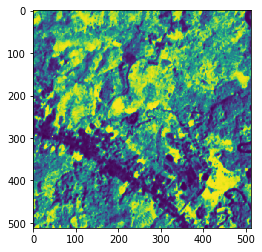

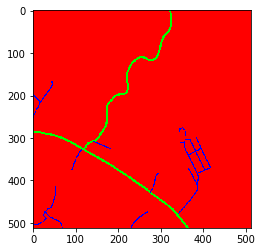

(512, 512, 4)


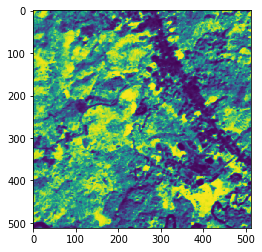

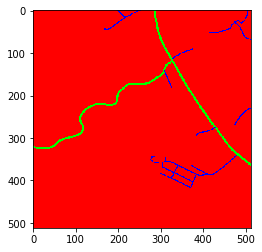

In [10]:
x = 2
print(train.name.iloc[x])
viewer(train[x:x+1], 1, aug_train, 2)

In [11]:
def get_fcn_vgg16_32s(input_size, n_classes, pretrained_weights=None):
    inputs = Input(input_size)

    x = BatchNormalization()(inputs)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#     # Block 4
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#     # Block 5
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Conv2D(128, (2, 2), activation='relu', padding="same")(x)
    
    x = Conv2DTranspose(n_classes, kernel_size=(64, 64), strides=(8, 8), activation='linear', padding='same')(x)
    
    model = Model(input=inputs, output=x)
  
    model.compile(optimizer=SGD(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [12]:

def get_unet(input_size, n_classes):
    inputs = Input(input_size)

    x = BatchNormalization()(inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='linear')(conv9)
    
    model = Model(input=inputs, output=conv10)
  
    model.compile(optimizer=SGD(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [13]:
model = get_unet((512,512, 4),3)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 1184        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [ ]:
bs = 2
model_checkpoint = ModelCheckpoint('../../models/fcnnLL_02_09_18_00.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(
    imageLoader(train, bs, aug_train, 1),
    steps_per_epoch=trainSize // bs,
    epochs=5,#,
    callbacks=[model_checkpoint],
    validation_data=imageLoader(test, bs, aug_val, 1),
    validation_steps= testSize // bs
)

Epoch 1/5


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history["acc"], label="acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

plot_history(history.history)